# Screen Modelling And Clustering for ASD

In [1]:
import sqlite3
from sqlite3 import Error
from sqlite3 import IntegrityError
from ipyfilechooser import FileChooser
import pandas as pd
import io
import requests
import numpy
import seaborn as sns
from scipy import stats
import math
from scipy.stats import ttest_ind
import tqdm

## Clustering Playtest

The below cells are for exploring clustering functionalities. Currently under development.

In [2]:
conn = sqlite3.connect('/Users/Joseph/Desktop/NRSC510B/mwt_data.db')
tstat_gene = pd.read_sql_query(f"SELECT * FROM tstat_gene_data", conn)
conn.close()

In [3]:
data = tstat_gene.drop(tstat_gene[tstat_gene.Gene == "N2"].index)
data = data.drop(columns=['Spontaneous Recovery of Response Duration',
                          'Spontaneous Recovery of Response Probability',
                          'Spontaneous Recovery of Response Speed'])
data_na = data.dropna().reset_index().drop(columns=['index'])
data_na.head(10)

,Gene,Width,Length,Area,Instantaneous Speed,Interval Speed,Angular Speed,Bias,Aspect Ratio,Kink,...,Initial Response Duration,Initial Response Probability,Initial Response Speed,Final Response Duration,Final Response Probability,Final Response Speed,Habituation of Response Duration,Habituation of Respones Probability,Habituation of Response Speed,Screen
0,C29E4.10,-0.647055,-0.185658,-0.439891,0.902499,0.928335,1.204435,1.017620,-0.249281,-0.597715,...,-0.382671,-1.116753,0.364692,-1.973002,-0.538532,-0.441958,0.089889,-1.065384,0.992830,PD_Screen
1,F32D8.13,0.777410,0.113354,0.436028,-0.246369,-0.123728,-0.476608,-0.002676,-0.013489,-0.149009,...,0.496580,-0.442789,-0.432684,0.196056,-0.567687,0.251047,0.357877,0.811631,-0.894162,PD_Screen
2,F53B2.5,-0.301572,-0.184646,-0.406214,2.560500,1.611415,2.544994,2.637826,0.616906,0.196222,...,0.880319,0.359874,1.192820,1.398358,-0.149340,-0.141870,0.151822,0.550300,2.532725,PD_Screen
3,F54B11.5,-0.833726,-0.436230,-0.755943,0.667368,0.703403,0.875220,0.711684,-0.417555,-0.372645,...,-0.220220,-1.279735,0.368981,-0.094378,-1.292243,0.214204,-0.199469,-0.766943,0.753337,PD_Screen
4,F55C5.7,-0.735903,-1.264234,-0.681969,-0.386983,-0.730350,-0.194881,0.192844,-0.376255,-0.629048,...,2.599804,-0.170001,-0.567830,0.393475,2.865312,-0.443459,1.819301,-1.971032,-0.075419,PD_Screen
5,T08G11.1,-1.088150,-1.824558,-1.687120,0.171246,0.214668,0.781983,0.411728,1.001609,0.770279,...,0.348635,-0.210835,0.027378,-0.147517,-0.173955,-0.785603,0.362031,-0.084357,0.595634,PD_Screen
6,T20F7.3,-0.503499,-0.469091,-0.470265,-0.185138,-0.307934,-0.135628,-0.417237,-0.701360,-0.749175,...,0.274552,0.248204,-0.098735,-2.066209,0.799006,-1.561896,1.277824,-0.723535,0.974643,PD_Screen
7,W07B8.4,-0.576967,-0.620720,-0.424708,0.494724,0.273801,0.514285,0.502154,-0.545952,-0.977184,...,1.524722,0.323142,1.324903,-0.623930,1.583315,0.471669,1.933788,-1.590346,0.998082,PD_Screen
8,W07B8.5,0.387555,0.033065,0.424338,-0.055088,-0.314784,0.104489,0.021153,-0.086559,-0.487370,...,1.338575,-0.101845,0.501077,0.331478,1.332169,-0.244955,1.136567,-1.116342,0.667734,PD_Screen
9,Y18D10A.22,-0.809437,-0.772804,-0.691180,-0.002940,-0.070907,-0.273864,0.726390,0.084552,-0.173583,...,0.752436,-0.023713,-0.259683,1.019924,0.445450,-0.737660,0.424853,-0.343837,0.169857,PD_Screen


In [4]:
DOP_Genes=['cat-2','dop-3','bas-1','dat-1','dop-1','cat-1']

In [5]:
PARK_Genes=['T08G11.1',
            'djr-1.1',
            'djr-1.2',
            'ifg-1',
            'rme-8',
            'vps-35',
            'pdr-1',
            'pink-1',
            'lrk-1',
            'catp-6',
            'cats-7',
            'gba-1',
            'gba-2',
            'gba-4',
            'gba-3',
            'ubh-1',
            'ubh-2',
            'ubh-3',
            'gyf-1',
            'ipla-3',
            'unc-26']
print(PARK_Genes)

['T08G11.1', 'djr-1.1', 'djr-1.2', 'ifg-1', 'rme-8', 'vps-35', 'pdr-1', 'pink-1', 'lrk-1', 'catp-6', 'cats-7', 'gba-1', 'gba-2', 'gba-4', 'gba-3', 'ubh-1', 'ubh-2', 'ubh-3', 'gyf-1', 'ipla-3', 'unc-26']


In [6]:
for i in range(len(data_na)):
    if data_na.loc[i, "Gene"] in DOP_Genes:
        data_na.loc[i, "Screen"] = "DOPAMINE"

In [7]:
data_na.head(20)

,Gene,Width,Length,Area,Instantaneous Speed,Interval Speed,Angular Speed,Bias,Aspect Ratio,Kink,...,Initial Response Duration,Initial Response Probability,Initial Response Speed,Final Response Duration,Final Response Probability,Final Response Speed,Habituation of Response Duration,Habituation of Respones Probability,Habituation of Response Speed,Screen
0,C29E4.10,-0.647055,-0.185658,-0.439891,0.902499,0.928335,1.204435,1.017620,-0.249281,-0.597715,...,-0.382671,-1.116753,0.364692,-1.973002,-0.538532,-0.441958,0.089889,-1.065384,0.992830,PD_Screen
1,F32D8.13,0.777410,0.113354,0.436028,-0.246369,-0.123728,-0.476608,-0.002676,-0.013489,-0.149009,...,0.496580,-0.442789,-0.432684,0.196056,-0.567687,0.251047,0.357877,0.811631,-0.894162,PD_Screen
2,F53B2.5,-0.301572,-0.184646,-0.406214,2.560500,1.611415,2.544994,2.637826,0.616906,0.196222,...,0.880319,0.359874,1.192820,1.398358,-0.149340,-0.141870,0.151822,0.550300,2.532725,PD_Screen
3,F54B11.5,-0.833726,-0.436230,-0.755943,0.667368,0.703403,0.875220,0.711684,-0.417555,-0.372645,...,-0.220220,-1.279735,0.368981,-0.094378,-1.292243,0.214204,-0.199469,-0.766943,0.753337,PD_Screen
4,F55C5.7,-0.735903,-1.264234,-0.681969,-0.386983,-0.730350,-0.194881,0.192844,-0.376255,-0.629048,...,2.599804,-0.170001,-0.567830,0.393475,2.865312,-0.443459,1.819301,-1.971032,-0.075419,PD_Screen
5,T08G11.1,-1.088150,-1.824558,-1.687120,0.171246,0.214668,0.781983,0.411728,1.001609,0.770279,...,0.348635,-0.210835,0.027378,-0.147517,-0.173955,-0.785603,0.362031,-0.084357,0.595634,PD_Screen
6,T20F7.3,-0.503499,-0.469091,-0.470265,-0.185138,-0.307934,-0.135628,-0.417237,-0.701360,-0.749175,...,0.274552,0.248204,-0.098735,-2.066209,0.799006,-1.561896,1.277824,-0.723535,0.974643,PD_Screen
7,W07B8.4,-0.576967,-0.620720,-0.424708,0.494724,0.273801,0.514285,0.502154,-0.545952,-0.977184,...,1.524722,0.323142,1.324903,-0.623930,1.583315,0.471669,1.933788,-1.590346,0.998082,PD_Screen
8,W07B8.5,0.387555,0.033065,0.424338,-0.055088,-0.314784,0.104489,0.021153,-0.086559,-0.487370,...,1.338575,-0.101845,0.501077,0.331478,1.332169,-0.244955,1.136567,-1.116342,0.667734,PD_Screen
9,Y18D10A.22,-0.809437,-0.772804,-0.691180,-0.002940,-0.070907,-0.273864,0.726390,0.084552,-0.173583,...,0.752436,-0.023713,-0.259683,1.019924,0.445450,-0.737660,0.424853,-0.343837,0.169857,PD_Screen


# Playing with Feature Importance and Selection...

In [9]:
category = data_na.pop("Screen")
lut = dict(zip(category.unique(), "rbkkkk"))
row_colors = category.map(lut)
print(category)
print(category.unique())

KeyError: 'Screen'

In [10]:
gene_labels = data_na.pop("Gene")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


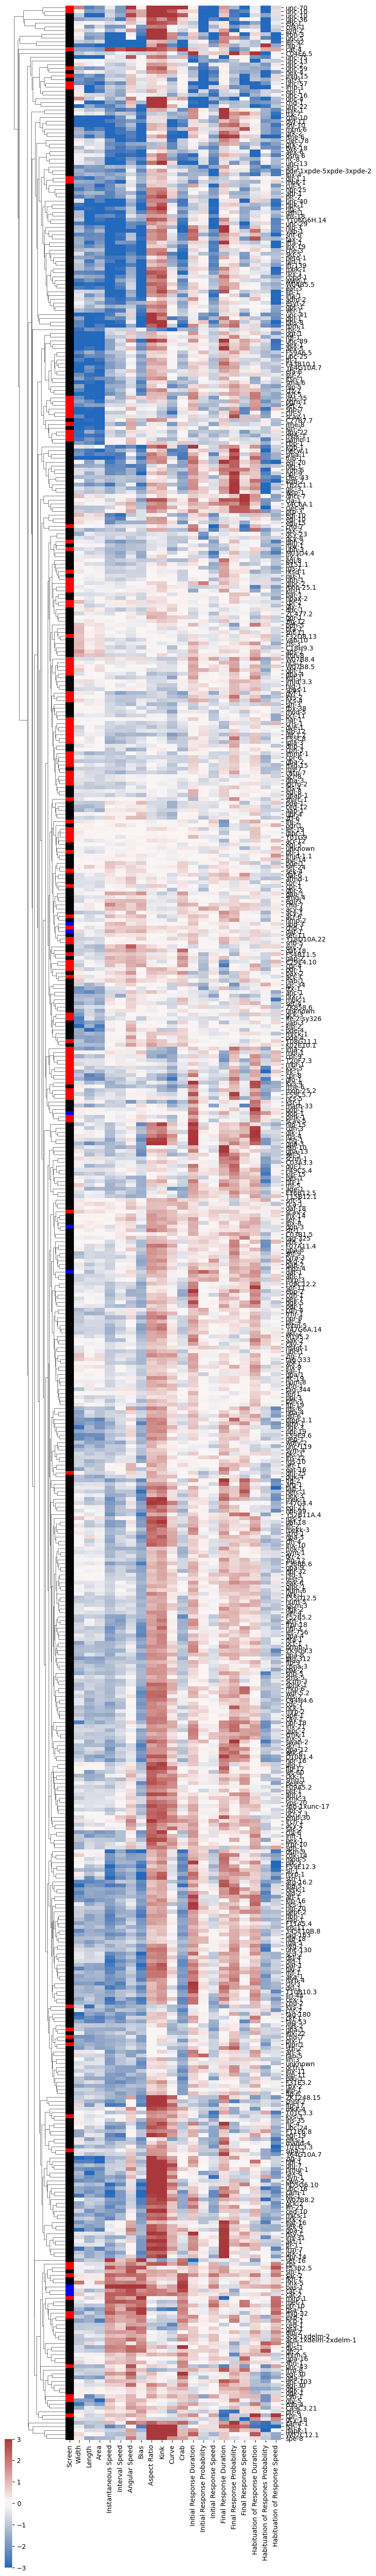

In [11]:
sns.clustermap(
    data_na,
    figsize=(8, 55),
    dendrogram_ratio=(0.2,0),
    cmap=sns.color_palette("vlag", as_cmap=True),
    vmax=3,
    vmin=-3,
    cbar_pos=(0, 0, 0.02, 0.05),
    row_colors=row_colors,
    # method = 'ward',
    # metric = 'canberra',
    row_cluster=True,
    col_cluster=False,
    yticklabels=gene_labels,
)

## Set Input (X) and Output (Y, Classification)

In [12]:
# making labels(Gene), X(features) and Y (target)
Y = category
# Y
X = data_na
# X
labels = gene_labels
# labels

X
Y

0      PD_Screen
1      PD_Screen
2      PD_Screen
3      PD_Screen
4      PD_Screen
         ...    
638    PD_Screen
639    PD_Screen
640    PD_Screen
641    PD_Screen
642    PD_Screen
Name: Screen, Length: 643, dtype: object

In [22]:
print(Y.unique())
# Y = Y.replace("ASD_Screen", "Outgroup")
Y = Y.replace("PD_Screen", "Outgroup") #Rerun kernel with this for in for ASD
Y = Y.replace("Glia_Genes_Screen", "Outgroup")
Y = Y.replace("G-Proteins_Screen", "Outgroup")
Y = Y.replace("Neuron_Genes_Screen", "Outgroup")
Y = Y.replace("DOPAMINE", "Outgroup")
print(Y.unique())
list_Y=['ASD_Screen','Outgroup']
print(list_Y)

['Outgroup' 'ASD_Screen']
['Outgroup' 'ASD_Screen']
['ASD_Screen', 'Outgroup']


## Oversample

In [24]:
from imblearn.over_sampling import SVMSMOTE
from collections import Counter

oversample = SVMSMOTE()
X_Oversampled, Y_Oversampled = oversample.fit_resample(X,Y)

counter = Counter(Y_Oversampled)
counter_og = Counter(Y)

print(counter)
print(counter_og)

Counter({'Outgroup': 566, 'ASD_Screen': 566})
Counter({'Outgroup': 566, 'ASD_Screen': 77})


## Random Forrest Classifier

<Axes: xlabel='Features'>

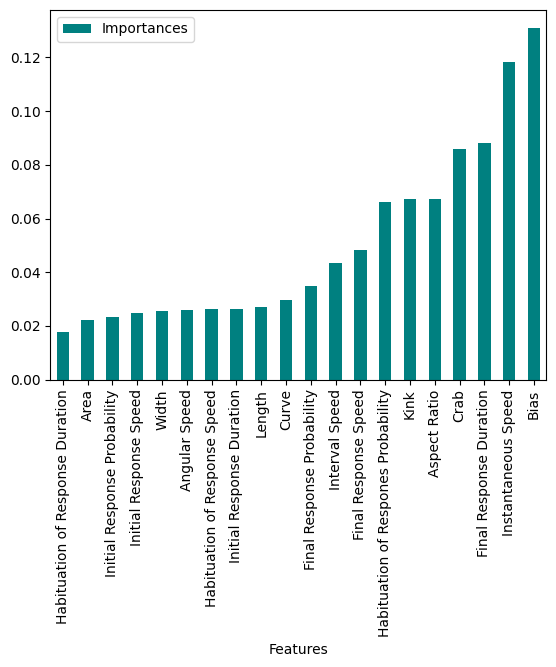

In [34]:
from sklearn.ensemble import RandomForestClassifier

# create random forest model with hyperparameters (keeping default to start)
model = RandomForestClassifier()
model.fit(X_Oversampled, Y_Oversampled)

# get the importance of the resulting features
importances = model.feature_importances_

# create a dataframe for visualization
final_df = pd.DataFrame({"Features": X.columns, "Importances":importances})
final_df.set_index('Importances')
# print(final_df)

# sort in ascending order to better visualzation
final_df = final_df.sort_values('Importances')

# plot the feature importance in bars
final_df.plot.bar(x = 'Features', y='Importances',color = 'teal')

# Splitting the dataset into training and testing sets
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


## Information Gain

<Axes: xlabel='Features'>

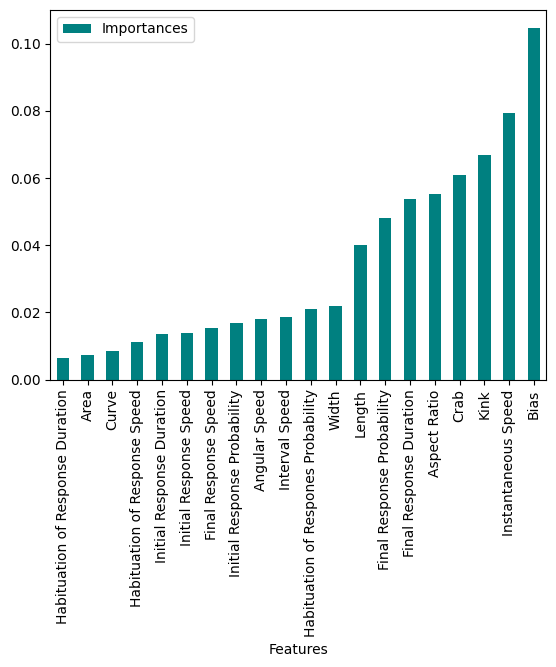

In [33]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline

importances = mutual_info_classif(X,Y)
# create a dataframe for visualization
final_df = pd.DataFrame({"Features": X.columns, "Importances":importances})
final_df.set_index('Importances')
# print(final_df)
# sort in ascending order to better visualzation
final_df = final_df.sort_values('Importances')
# plot the feature importance in bars
final_df.plot(kind='bar',x = 'Features', y='Importances',color = 'teal')


## Fisher Score

<Axes: xlabel='Features'>

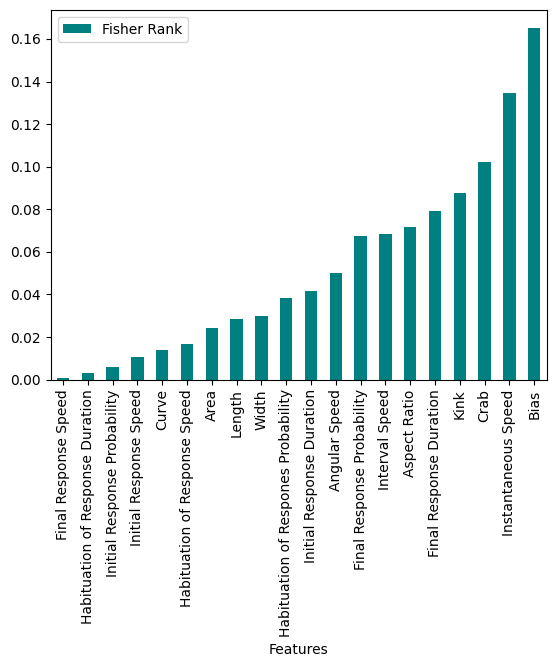

In [28]:
from skfeature.function.similarity_based import fisher_score
%matplotlib inline

ranks = fisher_score.fisher_score(X.to_numpy(),Y.to_numpy())

# create a dataframe for visualization
final_df = pd.DataFrame({"Features": X.columns, "Fisher Rank":ranks})
final_df.set_index('Fisher Rank')
# print(final_df)
# sort in ascending order to better visualzation
final_df = final_df.sort_values('Fisher Rank')
# plot the feature importance in bars
final_df.plot(kind='bar',x = 'Features', y='Fisher Rank',color = 'teal')

## Univariate (ANOVA) Modeling

In [29]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# # Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Applying ANOVA-based feature selection
k_best = 10  # Choose the number of top features you want to select
selector = SelectKBest(f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train, Y_train)
X_test_selected = selector.transform(X_test)

# Displaying selected feature indices
selected_indices = np.where(selector.get_support())[0]
selected_features = X.columns[selected_indices]
print("Selected feature indices:", selected_indices)
print("Selected features:", selected_features)
# print(X_train_selected)
# Optionally, you can train a model on the selected features
# For example, using a simple classifier like Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()
model.fit(X_train_selected, Y_train)
# Accuracy 0.8217054263565892

# model = LogisticRegression(random_state=42)  
# model.fit(X_train_selected, Y_train)
# Accuracy 0.7286821705426356

# Predicting on the test set
y_pred = model.predict(X_test_selected)

# Evaluating the model
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy on the test set:", accuracy)


Selected feature indices: [ 3  4  5  6  7  8 10 11 14 15]
Selected features: Index(['Instantaneous Speed', 'Interval Speed', 'Angular Speed', 'Bias',
       'Aspect Ratio', 'Kink', 'Crab', 'Initial Response Duration',
       'Final Response Duration', 'Final Response Probability'],
      dtype='object')
Accuracy on the test set: 0.8992248062015504


## Forward Feature Selection

In [30]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# # Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Applying ANOVA-based feature selection
k_best = 10  # Choose the number of top features you want to select
selector = SelectKBest(f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train, Y_train)
X_test_selected = selector.transform(X_test)

# Displaying selected feature indices
selected_indices = np.where(selector.get_support())[0]
selected_features = X.columns[selected_indices]
print("Selected feature indices:", selected_indices)
print("Selected features:", selected_features)
# print(X_train_selected)
# Optionally, you can train a model on the selected features
# For example, using a simple classifier like Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()
model.fit(X_train_selected, Y_train)
# Accuracy 0.8217054263565892

# model = LogisticRegression(random_state=42)  
# model.fit(X_train_selected, Y_train)
# Accuracy 0.7286821705426356

# Predicting on the test set
y_pred = model.predict(X_test_selected)

# Evaluating the model
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy on the test set:", accuracy)


Selected feature indices: [ 3  4  5  6  7  8 10 11 14 15]
Selected features: Index(['Instantaneous Speed', 'Interval Speed', 'Angular Speed', 'Bias',
       'Aspect Ratio', 'Kink', 'Crab', 'Initial Response Duration',
       'Final Response Duration', 'Final Response Probability'],
      dtype='object')
Accuracy on the test set: 0.875968992248062


## More involved algorithms (still forward feature selection, but this time using Random Forest)

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def forward_feature_selection(X_train, X_test, y_train, y_test, model, max_features=10):
    """
    Forward Feature Selection
    """
    selected_features = []
    best_score = 0

    while len(selected_features) < max_features if max_features else X_train.shape[1]:
        remaining_features = [feature for feature in range(X_train.shape[1]) if feature not in selected_features]
        candidate_scores = []

        for feature in remaining_features:
            current_features = selected_features + [feature]
            model.fit(X_train[:, current_features], y_train)
            y_pred = model.predict(X_test[:, current_features])
            score = accuracy_score(y_test, y_pred)
            candidate_scores.append((feature, score))

        # Select the feature that gives the best score
        best_candidate = max(candidate_scores, key=lambda x: x[1])

        # Check if adding the feature improves the model
        if best_candidate[1] > best_score:
            selected_features.append(best_candidate[0])
            best_score = best_candidate[1]
        else:
            break

    return selected_features

# Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# # Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_Oversampled, Y_Oversampled, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier()

# Performing forward feature selection
selected_features = forward_feature_selection(X_train, X_test, y_train, y_test, model)

print("Selected feature indices:", selected_features)
print("Selected features:", X.columns[selected_features])

# Optionally, you can train a model on the selected features
model.fit(X_train[:, selected_features], y_train)
y_pred = model.predict(X_test[:, selected_features])
y_prob = np.max(model.predict_proba(X_test[:, selected_features]), axis=1)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)

# pred_conf = pd.DataFrame(np.array([y_pred, y_prob]), columns = ["Prediction", "Confidence"])
d = {'prediction': y_pred, 'confidence': y_prob, "class":y_test}
df = pd.DataFrame(data=d)
print(df)
# print(pred_conf)

Selected feature indices: [6, 12, 14, 19, 0, 11, 13]
Selected features: Index(['Bias', 'Initial Response Probability', 'Final Response Duration',
       'Habituation of Response Speed', 'Width', 'Initial Response Duration',
       'Initial Response Speed'],
      dtype='object')
Accuracy on the test set: 0.9515418502202643
     prediction  confidence       class
783  ASD_Screen        0.80  ASD_Screen
898  ASD_Screen        0.65  ASD_Screen
413    Outgroup        0.98    Outgroup
467    Outgroup        1.00    Outgroup
745  ASD_Screen        0.84  ASD_Screen
..          ...         ...         ...
66     Outgroup        0.77    Outgroup
896  ASD_Screen        0.73  ASD_Screen
67   ASD_Screen        0.55    Outgroup
549    Outgroup        0.98    Outgroup
436    Outgroup        1.00    Outgroup

[227 rows x 3 columns]


## For selected features from feature selection processes above:

In [45]:
selected_features = [6, 12, 14, 19, 0, 11, 13]

print("Selected feature indices:", selected_features)
print("Selected features:", X.columns[selected_features])

# # Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_Oversampled, Y_Oversampled, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier()

# Optionally, you can train a model on the selected features
model.fit(X_train[:, selected_features], y_train)
y_pred = model.predict(X_test[:, selected_features])
y_prob = np.max(model.predict_proba(X_test[:, selected_features]), axis=1) 

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)

# pred_conf = pd.DataFrame(np.array([y_pred, y_prob]), columns = ["Prediction", "Confidence"])
d = {'prediction': y_pred, 'confidence': y_prob, "class":y_test}
df = pd.DataFrame(data=d)
print(df)

Selected feature indices: [6, 12, 14, 19, 0, 11, 13]
Selected features: Index(['Bias', 'Initial Response Probability', 'Final Response Duration',
       'Habituation of Response Speed', 'Width', 'Initial Response Duration',
       'Initial Response Speed'],
      dtype='object')
Accuracy on the test set: 0.9647577092511013
     prediction  confidence       class
783  ASD_Screen        0.75  ASD_Screen
898  ASD_Screen        0.57  ASD_Screen
413    Outgroup        0.95    Outgroup
467    Outgroup        1.00    Outgroup
745  ASD_Screen        0.85  ASD_Screen
..          ...         ...         ...
66     Outgroup        0.73    Outgroup
896  ASD_Screen        0.78  ASD_Screen
67   ASD_Screen        0.51    Outgroup
549    Outgroup        1.00    Outgroup
436    Outgroup        1.00    Outgroup

[227 rows x 3 columns]


### Saving the model:

In [46]:
from joblib import dump, load
dump(model, '/Users/Joseph/Desktop/NRSC510B/ASD_Screen_Model.joblib') 

['/Users/Joseph/Desktop/NRSC510B/ASD_Screen_Model.joblib']

In [85]:
for col in X.columns:
    print(col)

Width
Length
Area
Instantaneous Speed
Interval Speed
Angular Speed
Bias
Aspect Ratio
Kink
Curve
Crab
Initial Response Duration
Initial Response Probability
Initial Response Speed
Final Response Duration
Final Response Probability
Final Response Speed
Habituation of Response Duration
Habituation of Respones Probability
Habituation of Response Speed


## ROC Curve

Text(0, 0.5, 'recall')

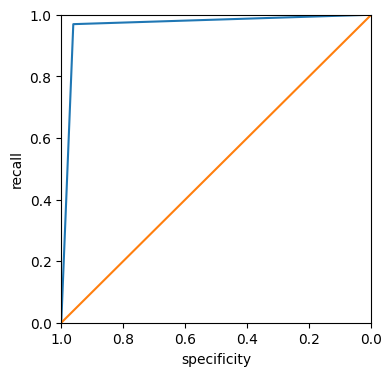

In [48]:
from sklearn.metrics import roc_curve as roc_curve

def binaryize(inlist):
    for i in range(len(inlist)):
        if inlist[i] == 'Outgroup':
            inlist[i] = 0
        if inlist[i] == 'ASD_Screen':
            inlist[i] = 1
    return inlist

y_test_binary = binaryize(y_test.tolist())
y_pred_binary = binaryize(y_pred)

fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary, pos_label=1)
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1-fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4,4), legend=False)
ax.set_ylim(0,1)
ax.set_xlim(1,0)
ax.plot((1,0),(0,1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')

In [49]:
from sklearn.metrics import roc_auc_score 

print(np.sum(roc_df.recall[:-1]*np.diff(1-roc_df.specificity)))
print(roc_auc_score([1 if yi == 1 else 0 for yi in y_test_binary],
                    y_pred_binary))

0.9318145862996361
0.96531403258978


## Backward Feature Elimination

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def backward_feature_elimination(X_train, X_test, y_train, y_test, model):
    """
    Backward Feature Elimination
    """
    sselected_features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# 10 features: 0.8449612403100775
# 7 features: 0.8449612403100775 <--- 7 features sweet spot
# 6 features: 0.8294573643410853
    while len(sselected_features) > 6:
        current_score = 0
        worst_feature = None

        for feature in sselected_features:
            remaining_features = [f for f in sselected_features if f != feature]
            model.fit(X_train[:, remaining_features], y_train)
            y_pred = model.predict(X_test[:, remaining_features])
            score = accuracy_score(y_test, y_pred)

            if score > current_score:
                current_score = score
                worst_feature = feature

        if worst_feature is not None:
            sselected_features.remove(worst_feature)
        else:
            break

    return sselected_features

# Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(X_train.shape)
# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Performing Backward Feature Elimination (BFE)
sselected_features = backward_feature_elimination(X_train, X_test, y_train, y_test, model)

print("Selected feature indices:", sselected_features)
print("Selected features:", X.columns[sselected_features])

# Optionally, you can train a model on the selected features
model.fit(X_train[:, sselected_features], y_train)
y_pred = model.predict(X_test[:, sselected_features])

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)


Selected feature indices: [3, 8, 14, 15, 17, 18]
Selected features: Index(['Instantaneous Speed', 'Kink', 'Final Response Duration',
       'Final Response Probability', 'Habituation of Response Duration',
       'Habituation of Respones Probability'],
      dtype='object')
Accuracy on the test set: 0.8294573643410853


## Recursive Feature Elimination

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

# Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Performing Recursive Feature Elimination (RFE)
num_features_to_select = 5  # Choose the number of features to select
rfe = RFE(estimator=model, n_features_to_select=num_features_to_select)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Displaying selected feature indices
selected_features = [i for i in range(len(rfe.support_)) if rfe.support_[i]]
print("Selected feature indices:", selected_features)
print("Selected feature indices:", X.columns[selected_features])

# Optionally, you can train a model on the selected features
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)


Selected feature indices: [6, 7, 8, 14, 18]
Selected feature indices: Index(['Bias', 'Aspect Ratio', 'Kink', 'Final Response Duration',
       'Habituation of Respones Probability'],
      dtype='object')
Accuracy on the test set: 0.8062015503875969


# Now Performing Clustering Of ASD_Screen Only for Profile Sub-types

In [108]:
# print(tstat_gene.shape)
# print(tstat_gene.columns)
# print(tstat_gene.Screen.unique())
# print(tstat_gene.Gene[tstat_gene.Screen == "PD_Screen"])
PD_Screen = tstat_gene[tstat_gene.Screen == "ASD_Screen"].reset_index().drop(columns=['index'])
PD_Screen

,Gene,Width,Length,Area,Instantaneous Speed,Interval Speed,Angular Speed,Bias,Aspect Ratio,Kink,...,Final Response Duration,Final Response Probability,Final Response Speed,Habituation of Response Duration,Habituation of Respones Probability,Habituation of Response Speed,Spontaneous Recovery of Response Duration,Spontaneous Recovery of Response Probability,Spontaneous Recovery of Response Speed,Screen
0,C18H9.3,0.940727,0.194177,0.435323,-0.616387,-0.933432,-0.512625,-0.906314,-0.115086,-0.113857,...,0.374578,0.247706,0.206590,0.431994,-1.000768,-0.852143,-1.318852,-0.155070,-0.019061,ASD_Screen
1,M03D4.4,-0.150020,-0.791369,-0.629753,-1.329001,-1.685624,-0.787482,-1.528013,-0.026771,0.213912,...,-0.439289,0.987110,-0.532434,0.692922,-1.583784,-2.570717,0.380095,-0.861078,-0.553324,ASD_Screen
2,N2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ASD_Screen
3,R151.1,-0.095614,-0.545433,-0.581830,-1.093169,-1.399185,-1.083517,-0.672784,0.274941,0.713870,...,1.459391,0.179927,-1.214247,-0.915533,-0.135349,-1.062773,-0.526730,0.898770,0.099055,ASD_Screen
4,ZK858.6,-0.860502,-0.540469,-0.659422,0.136818,-0.072119,0.610141,0.053918,0.233398,-0.079960,...,-0.551079,-0.444824,0.173807,-0.276494,0.901949,-1.131573,-0.088358,0.937166,0.296638,ASD_Screen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,unc-4,1.697597,-0.914467,-0.283482,-1.475994,-0.852815,1.872147,-0.168112,3.886903,3.200391,...,-2.117566,-4.073790,-0.000899,-2.373928,-2.977531,-1.144794,0.522798,0.296344,-0.771493,ASD_Screen
74,unc-75,-3.422406,-3.796192,-4.700223,0.182448,-0.504601,2.547544,-0.038110,1.955491,2.086112,...,-3.108427,0.070456,-0.098484,-2.032740,-2.408634,0.043558,1.657490,-1.522058,0.361002,ASD_Screen
75,unknown,-1.623364,-0.740658,-1.523966,0.285889,0.415973,0.408889,0.075470,-0.300840,-0.139715,...,-0.036111,-0.354254,0.700393,-0.063418,0.279533,-0.671497,-1.275242,-0.084424,-2.247502,ASD_Screen
76,vab-10,0.890670,0.360246,0.478454,-0.690072,-0.493535,-0.959294,-0.610486,-0.026438,-0.028862,...,0.288109,-0.429302,0.273549,-0.028272,0.562792,-0.970456,-0.361475,1.308687,0.063209,ASD_Screen


In [109]:
print(PD_Screen[PD_Screen.Gene == 'N2'])
PD_Screen = PD_Screen.drop([2])
print(PD_Screen[PD_Screen.Gene == 'N2']) 

  Gene  Width  Length  Area  Instantaneous Speed  Interval Speed  \
2   N2    0.0     0.0   0.0                  0.0             0.0   

   Angular Speed  Bias  Aspect Ratio  Kink  ...  Final Response Duration  \
2            0.0   0.0           0.0   0.0  ...                      0.0   

   Final Response Probability  Final Response Speed  \
2                         0.0                   0.0   

   Habituation of Response Duration  Habituation of Respones Probability  \
2                               0.0                                  0.0   

   Habituation of Response Speed  Spontaneous Recovery of Response Duration  \
2                            0.0                                        0.0   

   Spontaneous Recovery of Response Probability  \
2                                           0.0   

   Spontaneous Recovery of Response Speed      Screen  
2                                     0.0  ASD_Screen  

[1 rows x 25 columns]
Empty DataFrame
Columns: [Gene, Width, Length, Ar

In [110]:
# PD_Screen = PD_Screen.drop(columns=['index'])
PD_Screen

,Gene,Width,Length,Area,Instantaneous Speed,Interval Speed,Angular Speed,Bias,Aspect Ratio,Kink,...,Final Response Duration,Final Response Probability,Final Response Speed,Habituation of Response Duration,Habituation of Respones Probability,Habituation of Response Speed,Spontaneous Recovery of Response Duration,Spontaneous Recovery of Response Probability,Spontaneous Recovery of Response Speed,Screen
0,C18H9.3,0.940727,0.194177,0.435323,-0.616387,-0.933432,-0.512625,-0.906314,-0.115086,-0.113857,...,0.374578,0.247706,0.206590,0.431994,-1.000768,-0.852143,-1.318852,-0.155070,-0.019061,ASD_Screen
1,M03D4.4,-0.150020,-0.791369,-0.629753,-1.329001,-1.685624,-0.787482,-1.528013,-0.026771,0.213912,...,-0.439289,0.987110,-0.532434,0.692922,-1.583784,-2.570717,0.380095,-0.861078,-0.553324,ASD_Screen
3,R151.1,-0.095614,-0.545433,-0.581830,-1.093169,-1.399185,-1.083517,-0.672784,0.274941,0.713870,...,1.459391,0.179927,-1.214247,-0.915533,-0.135349,-1.062773,-0.526730,0.898770,0.099055,ASD_Screen
4,ZK858.6,-0.860502,-0.540469,-0.659422,0.136818,-0.072119,0.610141,0.053918,0.233398,-0.079960,...,-0.551079,-0.444824,0.173807,-0.276494,0.901949,-1.131573,-0.088358,0.937166,0.296638,ASD_Screen
5,anc-1,-1.972727,-2.285821,-1.739887,-0.719948,-0.659971,0.835609,-0.519592,0.825648,0.414245,...,-0.085498,-0.287196,-0.189907,-0.506484,-0.230768,-1.584807,0.231069,0.034384,-0.596525,ASD_Screen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,unc-4,1.697597,-0.914467,-0.283482,-1.475994,-0.852815,1.872147,-0.168112,3.886903,3.200391,...,-2.117566,-4.073790,-0.000899,-2.373928,-2.977531,-1.144794,0.522798,0.296344,-0.771493,ASD_Screen
74,unc-75,-3.422406,-3.796192,-4.700223,0.182448,-0.504601,2.547544,-0.038110,1.955491,2.086112,...,-3.108427,0.070456,-0.098484,-2.032740,-2.408634,0.043558,1.657490,-1.522058,0.361002,ASD_Screen
75,unknown,-1.623364,-0.740658,-1.523966,0.285889,0.415973,0.408889,0.075470,-0.300840,-0.139715,...,-0.036111,-0.354254,0.700393,-0.063418,0.279533,-0.671497,-1.275242,-0.084424,-2.247502,ASD_Screen
76,vab-10,0.890670,0.360246,0.478454,-0.690072,-0.493535,-0.959294,-0.610486,-0.026438,-0.028862,...,0.288109,-0.429302,0.273549,-0.028272,0.562792,-0.970456,-0.361475,1.308687,0.063209,ASD_Screen


In [111]:
# for i in range(len(PD_Screen)):
#     if PD_Screen.loc[i, "Gene"] in DOP_Genes:
#         PD_Screen = PD_Screen.drop([i])
# PD_Screen = PD_Screen.reset_index().drop(columns=['index'])

In [112]:
PD_Screen

,Gene,Width,Length,Area,Instantaneous Speed,Interval Speed,Angular Speed,Bias,Aspect Ratio,Kink,...,Final Response Duration,Final Response Probability,Final Response Speed,Habituation of Response Duration,Habituation of Respones Probability,Habituation of Response Speed,Spontaneous Recovery of Response Duration,Spontaneous Recovery of Response Probability,Spontaneous Recovery of Response Speed,Screen
0,C18H9.3,0.940727,0.194177,0.435323,-0.616387,-0.933432,-0.512625,-0.906314,-0.115086,-0.113857,...,0.374578,0.247706,0.206590,0.431994,-1.000768,-0.852143,-1.318852,-0.155070,-0.019061,ASD_Screen
1,M03D4.4,-0.150020,-0.791369,-0.629753,-1.329001,-1.685624,-0.787482,-1.528013,-0.026771,0.213912,...,-0.439289,0.987110,-0.532434,0.692922,-1.583784,-2.570717,0.380095,-0.861078,-0.553324,ASD_Screen
3,R151.1,-0.095614,-0.545433,-0.581830,-1.093169,-1.399185,-1.083517,-0.672784,0.274941,0.713870,...,1.459391,0.179927,-1.214247,-0.915533,-0.135349,-1.062773,-0.526730,0.898770,0.099055,ASD_Screen
4,ZK858.6,-0.860502,-0.540469,-0.659422,0.136818,-0.072119,0.610141,0.053918,0.233398,-0.079960,...,-0.551079,-0.444824,0.173807,-0.276494,0.901949,-1.131573,-0.088358,0.937166,0.296638,ASD_Screen
5,anc-1,-1.972727,-2.285821,-1.739887,-0.719948,-0.659971,0.835609,-0.519592,0.825648,0.414245,...,-0.085498,-0.287196,-0.189907,-0.506484,-0.230768,-1.584807,0.231069,0.034384,-0.596525,ASD_Screen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,unc-4,1.697597,-0.914467,-0.283482,-1.475994,-0.852815,1.872147,-0.168112,3.886903,3.200391,...,-2.117566,-4.073790,-0.000899,-2.373928,-2.977531,-1.144794,0.522798,0.296344,-0.771493,ASD_Screen
74,unc-75,-3.422406,-3.796192,-4.700223,0.182448,-0.504601,2.547544,-0.038110,1.955491,2.086112,...,-3.108427,0.070456,-0.098484,-2.032740,-2.408634,0.043558,1.657490,-1.522058,0.361002,ASD_Screen
75,unknown,-1.623364,-0.740658,-1.523966,0.285889,0.415973,0.408889,0.075470,-0.300840,-0.139715,...,-0.036111,-0.354254,0.700393,-0.063418,0.279533,-0.671497,-1.275242,-0.084424,-2.247502,ASD_Screen
76,vab-10,0.890670,0.360246,0.478454,-0.690072,-0.493535,-0.959294,-0.610486,-0.026438,-0.028862,...,0.288109,-0.429302,0.273549,-0.028272,0.562792,-0.970456,-0.361475,1.308687,0.063209,ASD_Screen


In [113]:
X.columns[selected_features]
selected_features

[6, 12, 14, 19, 0, 11, 13]

In [114]:
selected_feature_names = PD_Screen.columns[selected_features]
print(selected_feature_names)
print(list(selected_feature_names))
type(list(selected_feature_names))

Index(['Angular Speed', 'Initial Response Duration', 'Initial Response Speed',
       'Habituation of Respones Probability', 'Gene', 'Crab',
       'Initial Response Probability'],
      dtype='object')
['Angular Speed', 'Initial Response Duration', 'Initial Response Speed', 'Habituation of Respones Probability', 'Gene', 'Crab', 'Initial Response Probability']


list

In [121]:
PD_Screen1 = PD_Screen[['Gene','Bias', 'Initial Response Probability', 'Final Response Duration',
       'Habituation of Response Speed', 'Width', 'Initial Response Duration',
       'Initial Response Speed']]

PD_Screen1

,Gene,Bias,Initial Response Probability,Final Response Duration,Habituation of Response Speed,Width,Initial Response Duration,Initial Response Speed
0,C18H9.3,-0.906314,-0.360607,0.374578,-0.852143,0.940727,0.700340,-0.243014
1,M03D4.4,-1.528013,-1.100815,-0.439289,-2.570717,-0.150020,0.379903,-2.667040
3,R151.1,-0.672784,0.020998,1.459391,-1.062773,-0.095614,0.377571,-1.560779
4,ZK858.6,0.053918,0.568282,-0.551079,-1.131573,-0.860502,-0.432375,-0.550180
5,anc-1,-0.519592,-0.551459,-0.085498,-1.584807,-1.972727,-0.450722,-0.983920
...,...,...,...,...,...,...,...,...
73,unc-4,-0.168112,-4.490112,-2.117566,-1.144794,1.697597,-3.119062,-1.419287
74,unc-75,-0.038110,-1.746796,-3.108427,0.043558,-3.422406,-2.689913,-0.080393
75,unknown,0.075470,0.085939,-0.036111,-0.671497,-1.623364,-0.060101,-0.228759
76,vab-10,-0.610486,0.215337,0.288109,-0.970456,0.890670,0.421469,-0.467175


In [122]:
PD_Screen_Genes=PD_Screen1.pop("Gene")

In [123]:
PD_Screen1

,Bias,Initial Response Probability,Final Response Duration,Habituation of Response Speed,Width,Initial Response Duration,Initial Response Speed
0,-0.906314,-0.360607,0.374578,-0.852143,0.940727,0.700340,-0.243014
1,-1.528013,-1.100815,-0.439289,-2.570717,-0.150020,0.379903,-2.667040
3,-0.672784,0.020998,1.459391,-1.062773,-0.095614,0.377571,-1.560779
4,0.053918,0.568282,-0.551079,-1.131573,-0.860502,-0.432375,-0.550180
5,-0.519592,-0.551459,-0.085498,-1.584807,-1.972727,-0.450722,-0.983920
...,...,...,...,...,...,...,...
73,-0.168112,-4.490112,-2.117566,-1.144794,1.697597,-3.119062,-1.419287
74,-0.038110,-1.746796,-3.108427,0.043558,-3.422406,-2.689913,-0.080393
75,0.075470,0.085939,-0.036111,-0.671497,-1.623364,-0.060101,-0.228759
76,-0.610486,0.215337,0.288109,-0.970456,0.890670,0.421469,-0.467175


In [118]:
feature_list = ['Bias', 'Initial Response Probability', 'Final Response Duration',
       'Habituation of Response Speed', 'Width', 'Initial Response Duration',
       'Initial Response Speed']

## K Means Clustering

In [124]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, n_init=10000,random_state=0).fit(PD_Screen1)

In [125]:
PD_Screen1['cluster'] = kmeans.labels_
PD_Screen1.head()

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_53691/398120266.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Bias,Initial Response Probability,Final Response Duration,Habituation of Response Speed,Width,Initial Response Duration,Initial Response Speed,cluster
0,-0.906314,-0.360607,0.374578,-0.852143,0.940727,0.700340,-0.243014,1
1,-1.528013,-1.100815,-0.439289,-2.570717,-0.150020,0.379903,-2.667040,0
3,-0.672784,0.020998,1.459391,-1.062773,-0.095614,0.377571,-1.560779,0
4,0.053918,0.568282,-0.551079,-1.131573,-0.860502,-0.432375,-0.550180,0
5,-0.519592,-0.551459,-0.085498,-1.584807,-1.972727,-0.450722,-0.983920,0


In [126]:
kmeans.labels_

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 2, 1, 0, 1, 1, 1, 0, 1, 0, 2,
       2, 3, 2, 2, 2, 1, 2, 2, 1, 2, 0, 1, 0, 2, 1, 1, 1, 0, 0, 2, 0, 1,
       1, 2, 1, 0, 0, 1, 1, 1, 2, 3, 0, 1, 0, 1, 3, 1, 0, 1, 0, 2, 1, 1,
       1, 0, 1, 3, 3, 3, 3, 3, 0, 1, 1], dtype=int32)

In [127]:
kmeans.cluster_centers_

array([[-0.45317967, -0.23177464, -0.14908388, -1.15406307, -0.97049576,
        -0.16036632, -0.84443148],
       [ 0.11576257, -0.21850255,  0.02823796, -0.42497545,  0.17690199,
         0.47545019,  0.07622439],
       [ 1.63002439,  0.05054065, -0.07551962,  1.13337549, -0.33197105,
         0.34155381,  0.73425146],
       [ 0.6933984 , -2.46488567, -1.86536137, -0.54262702, -0.61787945,
        -1.81555582, -1.73668584]])

In [128]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['Bias', 'Initial Response Probability', 'Final Response Duration',
       'Habituation of Response Speed', 'Width', 'Initial Response Duration',
       'Initial Response Speed'])
centers

,Bias,Initial Response Probability,Final Response Duration,Habituation of Response Speed,Width,Initial Response Duration,Initial Response Speed
0,-0.453180,-0.231775,-0.149084,-1.154063,-0.970496,-0.160366,-0.844431
1,0.115763,-0.218503,0.028238,-0.424975,0.176902,0.475450,0.076224
2,1.630024,0.050541,-0.075520,1.133375,-0.331971,0.341554,0.734251
3,0.693398,-2.464886,-1.865361,-0.542627,-0.617879,-1.815556,-1.736686


In [129]:
kmeans_counter=Counter(kmeans.labels_)
kmeans_counter

Counter({1: 31, 0: 24, 2: 14, 3: 8})

In [130]:
kmeans.labels_

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 2, 1, 0, 1, 1, 1, 0, 1, 0, 2,
       2, 3, 2, 2, 2, 1, 2, 2, 1, 2, 0, 1, 0, 2, 1, 1, 1, 0, 0, 2, 0, 1,
       1, 2, 1, 0, 0, 1, 1, 1, 2, 3, 0, 1, 0, 1, 3, 1, 0, 1, 0, 2, 1, 1,
       1, 0, 1, 3, 3, 3, 3, 3, 0, 1, 1], dtype=int32)

In [131]:
kmeans.n_features_in_

7

In [132]:
import matplotlib.pyplot as plt

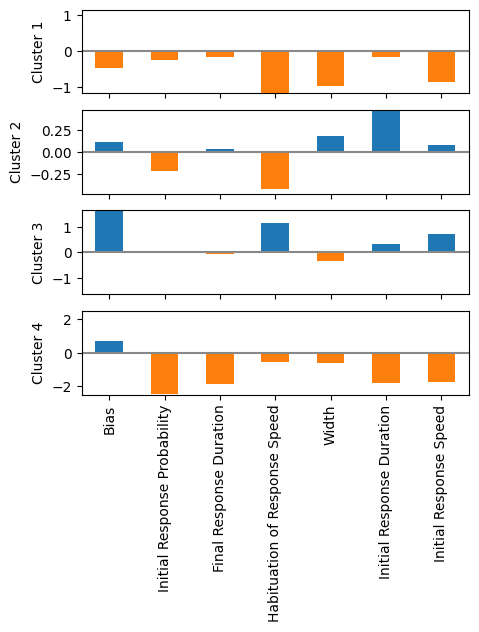

In [133]:
centers = pd.DataFrame(kmeans.cluster_centers_,columns=feature_list)

f,axes = plt.subplots(4,1, figsize=(5,5), sharex=True)
for i,ax in enumerate(axes):
    center = centers.loc[i,:]
    maxPC = 1.01*np.max(np.max(np.abs(center)))
    colors=['C0' if l>0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i+1}')
    ax.set_ylim(-maxPC, maxPC)

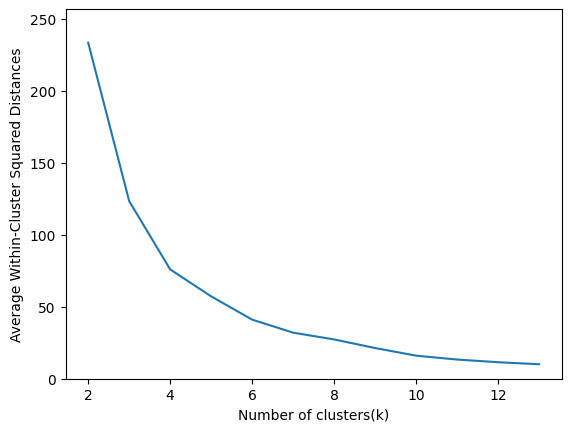

In [98]:
from sklearn.cluster import KMeans

inertia = []
for n_clusters in range(2,14):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0).fit(PD_Screen1)
    inertia.append(kmeans.inertia_ / n_clusters)

inertias = pd.DataFrame({'n_clusters': range(2,14), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0,1.1*inertias.inertia.max()))
ax.legend().set_visible(False)

In [134]:
centers

,Bias,Initial Response Probability,Final Response Duration,Habituation of Response Speed,Width,Initial Response Duration,Initial Response Speed
0,-0.453180,-0.231775,-0.149084,-1.154063,-0.970496,-0.160366,-0.844431
1,0.115763,-0.218503,0.028238,-0.424975,0.176902,0.475450,0.076224
2,1.630024,0.050541,-0.075520,1.133375,-0.331971,0.341554,0.734251
3,0.693398,-2.464886,-1.865361,-0.542627,-0.617879,-1.815556,-1.736686


In [97]:
# from plotly.subplots import make_subplots
# import plotly.express as px
# import plotly.graph_objects as go

# fig = make_subplots(cols=2, rows=2,
#                     specs=[[{"type": "polar"} for _ in range(2)] for _ in range(2)],
#                     # subplot_titles=("Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5")
#                    )


# fig.add_trace(
#     go.Scatterpolar(r = centers.iloc[0], theta = centers.columns, fill="toself",name="(Cluster 1)"),
#     row=1, col=1
# )


# fig.add_trace(
#     go.Scatterpolar(r = centers.iloc[1], theta = centers.columns, fill="toself",name="(Cluster 2)"),
#     row=1, col=2
# )

# fig.add_trace(
#     go.Scatterpolar(r = centers.iloc[2], theta = centers.columns, fill="toself",name="(Cluster 3)"),
#     row=2, col=1
# )

# fig.add_trace(
#     go.Scatterpolar(r = centers.iloc[3], theta = centers.columns, fill="toself",name="(Cluster 4)"),
#     row=2, col=2
# )



# fig.update_layout(
#   polar=dict(
#     radialaxis=dict(
#       visible=True
#     ),
#   ),
#   showlegend=False
# )

# fig.update_layout(height=1500, width=1000, template='plotly_dark',title_text="5 'Profiles' associated with PD genotype")
# fig.update_polars(radialaxis=dict(range=[-3, 3]))
# fig.show()

In [141]:
# centers.loc[row].values.flatten().tolist()
# list(centers)[0:]
# cols=['Habituation of Response Duration','Bias','Kink','Final Response Probability','Curve','Instantaneous Speed','Width']
# centers=centers[cols]
centers

,Bias,Initial Response Probability,Final Response Duration,Habituation of Response Speed,Width,Initial Response Duration,Initial Response Speed
0,-0.453180,-0.231775,-0.149084,-1.154063,-0.970496,-0.160366,-0.844431
1,0.115763,-0.218503,0.028238,-0.424975,0.176902,0.475450,0.076224
2,1.630024,0.050541,-0.075520,1.133375,-0.331971,0.341554,0.734251
3,0.693398,-2.464886,-1.865361,-0.542627,-0.617879,-1.815556,-1.736686


/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_53691/1622349973.py:50: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



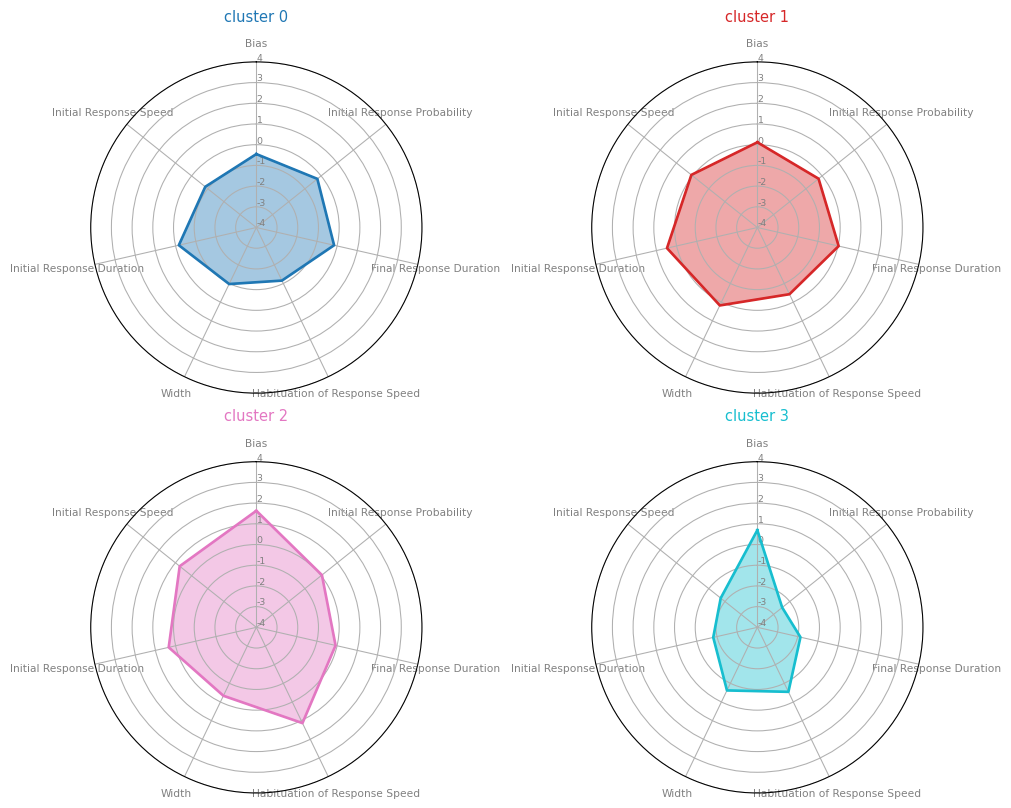

In [143]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
import matplotlib
 
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color):

    # number of variable
    categories=list(centers)[0:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([-5,-4,-3,-2,-1,0,1,2,3,4,5], ["-5","-4","-3","-2","-1","0","1","2","3","4","5"], color="grey", size=7)
    plt.ylim(-4,4)

    # Ind1
    values=centers.loc[row].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

    
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi, layout='compressed')
# Create a color palette:
my_palette = plt.cm.get_cmap("tab10", len(centers.index))
 
# Loop to plot
for row in range(0, len(centers.index)):
    make_spider(row=row, title='cluster '+str(centers.index[row]), color=my_palette(row))

### Stopped Here...

## Plotting Individual Genotypes

In [463]:
PD_Screen_plot = PD_Screen[['Gene','Bias', 'Kink', 'Width', 'Habituation of Response Duration', 'Final Response Probability', 'Curve', 'Instantaneous Speed']]

cols=['Gene','Habituation of Response Duration','Bias','Kink','Final Response Probability','Curve','Instantaneous Speed','Width']
PD_Screen_plot=PD_Screen_plot[cols]
PD_Screen_plot

,Gene,Habituation of Response Duration,Bias,Kink,Final Response Probability,Curve,Instantaneous Speed,Width
0,C29E4.10,0.089889,1.017620,-0.597715,-0.538532,-0.086174,0.902499,-0.647055
1,F32D8.13,0.357877,-0.002676,-0.149009,-0.567687,-0.300701,-0.246369,0.777410
2,F53B2.5,0.151822,2.637826,0.196222,-0.149340,0.194071,2.560500,-0.301572
3,F54B11.5,-0.199469,0.711684,-0.372645,-1.292243,0.036285,0.667368,-0.833726
4,F55C5.7,1.819301,0.192844,-0.629048,2.865312,-0.753195,-0.386983,-0.735903
...,...,...,...,...,...,...,...,...
102,smrc-1,-0.374855,0.179691,-0.611455,1.598069,-0.630578,0.124478,-0.508011
103,ubh-1,-0.579597,-0.407735,0.023788,0.476468,-0.151754,-0.763545,-0.166262
104,ubh-2,-0.116123,-1.420836,-0.369114,0.953872,-0.945813,-1.646930,-0.266350
105,ubh-3,0.562537,-1.087203,-0.253024,0.308447,-1.701094,-1.331446,-0.668687


In [464]:
PD_Screen_cluster = PD_Screen[['Gene','Bias', 'Kink', 'Width', 'Habituation of Response Duration', 'Final Response Probability', 'Curve', 'Instantaneous Speed']]
PD_Screen_cluster['cluster'] = kmeans.labels_
PD_Screen_cluster.head()

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_48731/4112531131.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Gene,Bias,Kink,Width,Habituation of Response Duration,Final Response Probability,Curve,Instantaneous Speed,cluster
0,C29E4.10,1.017620,-0.597715,-0.647055,0.089889,-0.538532,-0.086174,0.902499,1
1,F32D8.13,-0.002676,-0.149009,0.777410,0.357877,-0.567687,-0.300701,-0.246369,3
2,F53B2.5,2.637826,0.196222,-0.301572,0.151822,-0.149340,0.194071,2.560500,1
3,F54B11.5,0.711684,-0.372645,-0.833726,-0.199469,-1.292243,0.036285,0.667368,3
4,F55C5.7,0.192844,-0.629048,-0.735903,1.819301,2.865312,-0.753195,-0.386983,0


In [497]:
cols=['Gene','Habituation of Response Duration','Bias','Kink','Final Response Probability','Curve','Instantaneous Speed','Width','cluster']
PD_Screen_cluster=PD_Screen_cluster[cols]
PD_Screen_cluster

,Gene,Habituation of Response Duration,Bias,Kink,Final Response Probability,Curve,Instantaneous Speed,Width,cluster
0,C29E4.10,0.089889,1.017620,-0.597715,-0.538532,-0.086174,0.902499,-0.647055,1
1,F32D8.13,0.357877,-0.002676,-0.149009,-0.567687,-0.300701,-0.246369,0.777410,3
2,F53B2.5,0.151822,2.637826,0.196222,-0.149340,0.194071,2.560500,-0.301572,1
3,F54B11.5,-0.199469,0.711684,-0.372645,-1.292243,0.036285,0.667368,-0.833726,3
4,F55C5.7,1.819301,0.192844,-0.629048,2.865312,-0.753195,-0.386983,-0.735903,0
...,...,...,...,...,...,...,...,...,...
102,smrc-1,-0.374855,0.179691,-0.611455,1.598069,-0.630578,0.124478,-0.508011,0
103,ubh-1,-0.579597,-0.407735,0.023788,0.476468,-0.151754,-0.763545,-0.166262,3
104,ubh-2,-0.116123,-1.420836,-0.369114,0.953872,-0.945813,-1.646930,-0.266350,0
105,ubh-3,0.562537,-1.087203,-0.253024,0.308447,-1.701094,-1.331446,-0.668687,0


In [469]:
PD_Screen_plot['Gene'][0]

PD_Screen_plot.Gene[PD_Screen_plot.Gene == 'C29E4.10'].index

Index([0], dtype='int64')

In [472]:
import ipywidgets as widgets

Gene_Dropdown = widgets.Dropdown(
                    options=list(PD_Screen_plot['Gene']),
                    value=PD_Screen_plot['Gene'][0],
                    description='Gene:',
                    disabled=False,
                )
display(Gene_Dropdown)

Dropdown(description='Gene:', options=('C29E4.10', 'F32D8.13', 'F53B2.5', 'F54B11.5', 'F55C5.7', 'T08G11.1', '…

In [513]:
PD_Screen_cluster.loc[PD_Screen_cluster.Gene[PD_Screen_cluster.Gene == Gene_Dropdown.value].index].values.flatten().tolist()[:]

['lrk-1',
 1.272191365361104,
 -0.18059225123176953,
 -0.3829221656352354,
 1.4259476421311983,
 -1.0872157654709362,
 -0.6081690892160921,
 -1.3639846841626022,
 0]

In [514]:
PD_Screen_plot.loc[PD_Screen_plot.Gene[PD_Screen_plot.Gene == Gene_Dropdown.value].index].values.flatten().tolist()[:]

['lrk-1',
 1.272191365361104,
 -0.18059225123176953,
 -0.3829221656352354,
 1.4259476421311983,
 -1.0872157654709362,
 -0.6081690892160921,
 -1.3639846841626022]

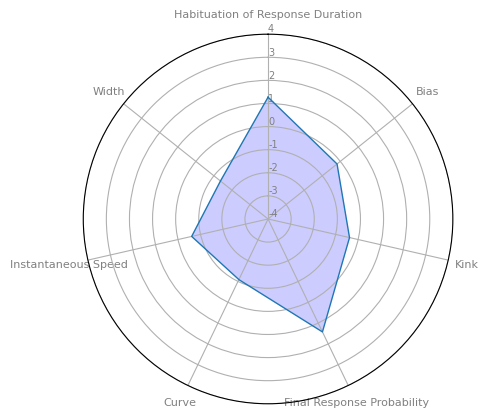

In [515]:

# number of variable
categories=list(PD_Screen_plot)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=PD_Screen_plot.loc[PD_Screen_plot.Gene[PD_Screen_plot.Gene == Gene_Dropdown.value].index].values.flatten().tolist()[1:]
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)



# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([-5,-4,-3,-2,-1,0,1,2,3,4,5], ["-5","-4","-3","-2","-1","0","1","2","3","4","5"], color="grey", size=7)
plt.ylim(-4,4)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# Fill area
ax.fill(angles, values, 'b', alpha=0.2)

# Show the graph
plt.show()